In [72]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import importlib
import time
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib inline

In [74]:
def upload_file(f_name, override=False):
  if override or not os.path.exists(f_name):
    timestamp = int(time.time())
    url = f'https://raw.githubusercontent.com/orwertheim/PublicProjects/main/K%20means%20Image%20compression/{f_name}?t={timestamp}'
    response = requests.get(url)
    with open(f_name, 'wb') as f:
      f.write(response.content)

In [75]:
upload_file('utils.py', override=True)
import utils

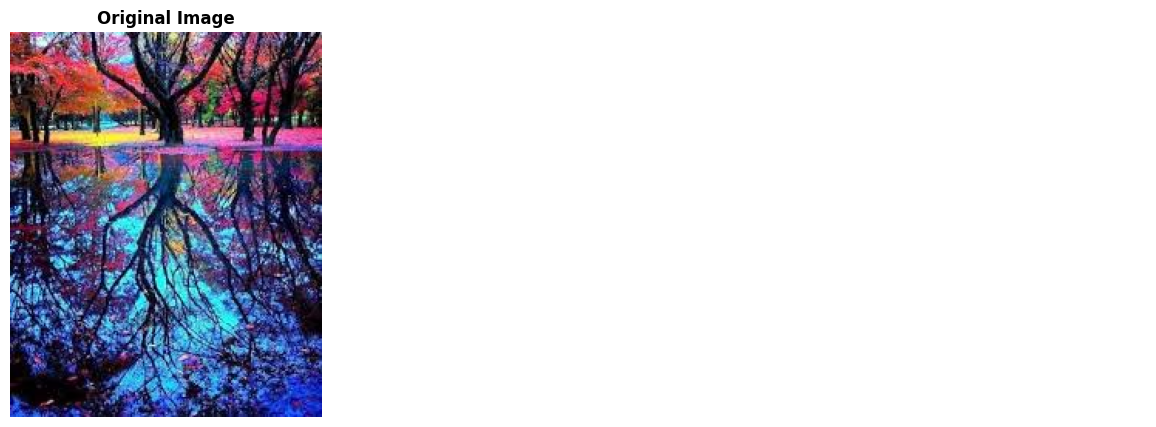

In [76]:
upload_file('colorImage1.png')
original_img = plt.imread('colorImage1.png')
utils.display_images([original_img],['Original Image'])

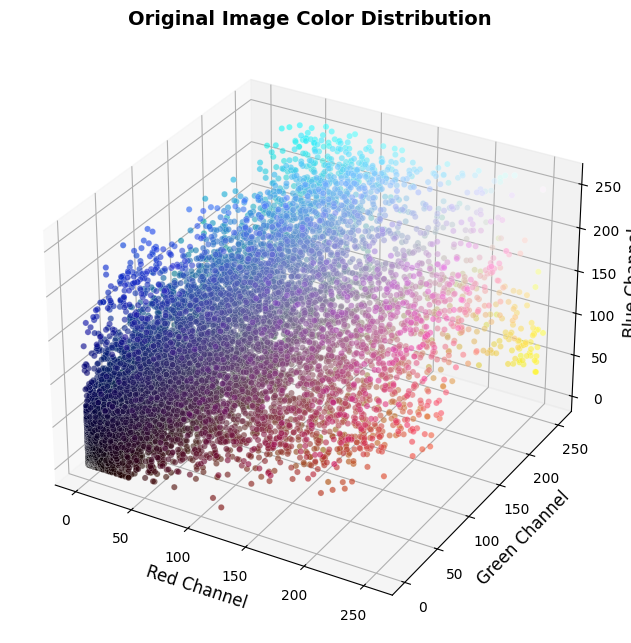

In [77]:
utils.plot_rgb_3d(original_img, title='Original Image Color Distribution')

In [78]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example

    Args:
        X (ndarray): (m, n) Input values
        centroids (ndarray): (K, n) centroids

    Returns:
        idx (array_like): (m,) closest centroids
    """

    # Calculate the squared Euclidean distance between each example and each centroid
    # Broadcasting: X (m, n) and centroids (K, n) => (m, K, n)
    diff = X[:, np.newaxis, :] - centroids  # (m, 1, n) - (K, n) => (m, K, n)
    sq_dist = np.sum(diff**2, axis=2)  # (m, K) squared distances between each example and each centroid

    # Find the index of the closest centroid (the one with the minimum distance)
    idx = np.argmin(sq_dist, axis=1)

    return idx

In [79]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the
    data points assigned to each centroid.

    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each
                       example in X. Concretely, idx[i] contains the index of
                       the centroid closest to example i
        K (int):       number of centroids

    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """

    m, n = X.shape
    centroids = np.zeros((K, n))

    #add each example features to the centroid it belongs to
    np.add.at(centroids, idx, X)

    #count how many examples for each centroid
    counts = np.bincount(idx, minlength=K).reshape(K,1)

    #prevent zero divition
    counts[counts == 0]=1

    #calculate mean
    centroids = centroids/counts

    return centroids


The cost function for K-Means clustering is the **Mean Squared Error** (MSE) between each data point and its assigned centroid.

$$
J = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} \mathbb{1}(i, k) \cdot \| x_i - \mu_k \|^2
$$

Where:
- $ x_i $ is the $ i $-th data point,
- $ \mu_k $ is the $ k $-th centroid,
- $ \mathbb{1}(i, k) $ is an indicator function that is 1 if data point \(i\) is assigned to centroid $ k $, and 0 otherwise,
- $ m $ is the total number of data points,
- $ K $ is the number of centroids.
- $ \| x_i - \mu_k \|^2 $ is the squared error.

This equation calculates the **sum of squared errors** (SSE) between each data point and its assigned centroid, and the cost is the average over all data points.


In [80]:
def compute_cost(X, centroids, idx):
    """
    Computes the cost function for K-Means clustering.

    Args:
        X (ndarray): (m, n) Input data, where m is the number of data points and n is the number of features.
        centroids (ndarray): (K, n) Centroids of the clusters, where K is the number of centroids.
        idx (ndarray): (m,) Index array where each element is the index of the centroid assigned to the corresponding data point.

    Returns:
        J (float): The computed cost (sum of squared errors) for the given centroids and assignments.
    """

    # Get the number of data points and centroids
    m = X.shape[0]

    # Efficiently compute the squared distances using broadcasting
    # X (m, n) -> subtract from the corresponding centroid (centroids[idx] will have shape (m, n))
    # The subtraction is done element-wise and then squared
    diff = X - centroids[idx]  # Shape: (m, n)
    squared_diff = np.sum(diff**2, axis=1)  # Sum the squared differences along the feature axis, result is shape (m,)

    # The cost is the average of the squared distances
    J = np.sum(squared_diff) / m

    return J

In [81]:
def run_kMeans(X, initial_centroids, max_iters=10, prints=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """

    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(m)
    # Run K-Means
    last_cost=-1

    #for i in tqdm(range(max_iters), desc="K-Means iterations", unit="item"):
    for i in range(max_iters):
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)

        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
        last_cost=compute_cost(X,centroids, idx)
        #Output progress
        if prints:
          print(f"K-Means iteration: {i}/{max_iters-1}, cost: {last_cost}")
    return centroids, idx, last_cost

In [82]:
def kMeans_init_centroids(X, K):
    """
    This function initializes K centroids that are to be
    used in K-Means on the dataset X

    Args:
        X (ndarray): Data points
        K (int):     number of centroids/clusters

    Returns:
        centroids (ndarray): Initialized centroids
    """

    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])

    # Take the first K examples as centroids
    centroids = X[randidx[:K]]

    return centroids

In [83]:
X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))

In [84]:
def plot_histogram(x, title='', x_label='', y_label='', bins=30, y_lim=None):
    """
    Plots a histogram of the costs from multiple K-Means initializations.

    Args:
        costs (ndarray or list): Array or list of cost values from different K-Means initializations.
    """
    plt.figure(figsize=(8, 6))

    # Plot histogram

    #plt.hist([list(range(1,len(x+1))),list(x)], bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    plt.plot(x, color='skyblue', marker='o', linestyle='', markersize=5, alpha=0.7)
    # Add titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)

    if y_lim is not None:
      plt.ylim(y_lim[0], y_lim[1])

    # Show plot
    plt.show()

In [85]:
# Run your K-Means algorithm on this data
# You should try different values of K and max_iters here
K = 16
max_iters = 10

initializations_count = 20

centroids_ar = []
cost_ar = []
idx_ar = []

for i in tqdm(range(initializations_count), desc="K-Means Runs", unit="Run"):
  # Using the function you have implemented above.
  initial_centroids = kMeans_init_centroids(X_img, K)

  # Run K-Means - this can take a couple of minutes depending on K and max_iters
  centroids, idx, cost = run_kMeans(X_img, initial_centroids, max_iters)
  centroids_ar.append(centroids); idx_ar.append(idx); cost_ar.append(cost)



K-Means Runs:   0%|          | 0/20 [00:00<?, ?Run/s]

min:<built-in function min>, max:0.017324815292599643
[np.float64(0.015271032349086357), np.float64(0.015429951446135005), np.float64(0.015804688931754456), np.float64(0.015839801878001485), np.float64(0.01541609457171051), np.float64(0.015907979805678374), np.float64(0.016231019764237867), np.float64(0.01600085541650054), np.float64(0.015448326024002791), np.float64(0.016030756898989237), np.float64(0.015219621820449582), np.float64(0.017088511474216278), np.float64(0.015112782018434802), np.float64(0.017081372940675056), np.float64(0.017007321671866967), np.float64(0.01508973907793625), np.float64(0.016774492602443798), np.float64(0.015471199971477794), np.float64(0.0163348437648493), np.float64(0.017324815292599643)]


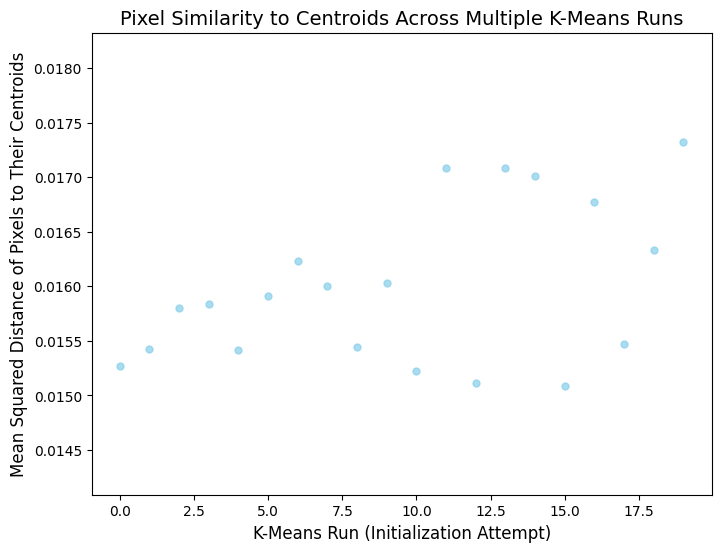

In [86]:
y_range = (np.min(cost_ar)-0.001, np.max(cost_ar)+0.001)
plot_histogram(cost_ar, y_label="Mean Squared Distance of Pixels to Their Centroids", x_label='K-Means Run (Initialization Attempt)', title='Pixel Similarity to Centroids Across Multiple K-Means Runs', y_lim=y_range)

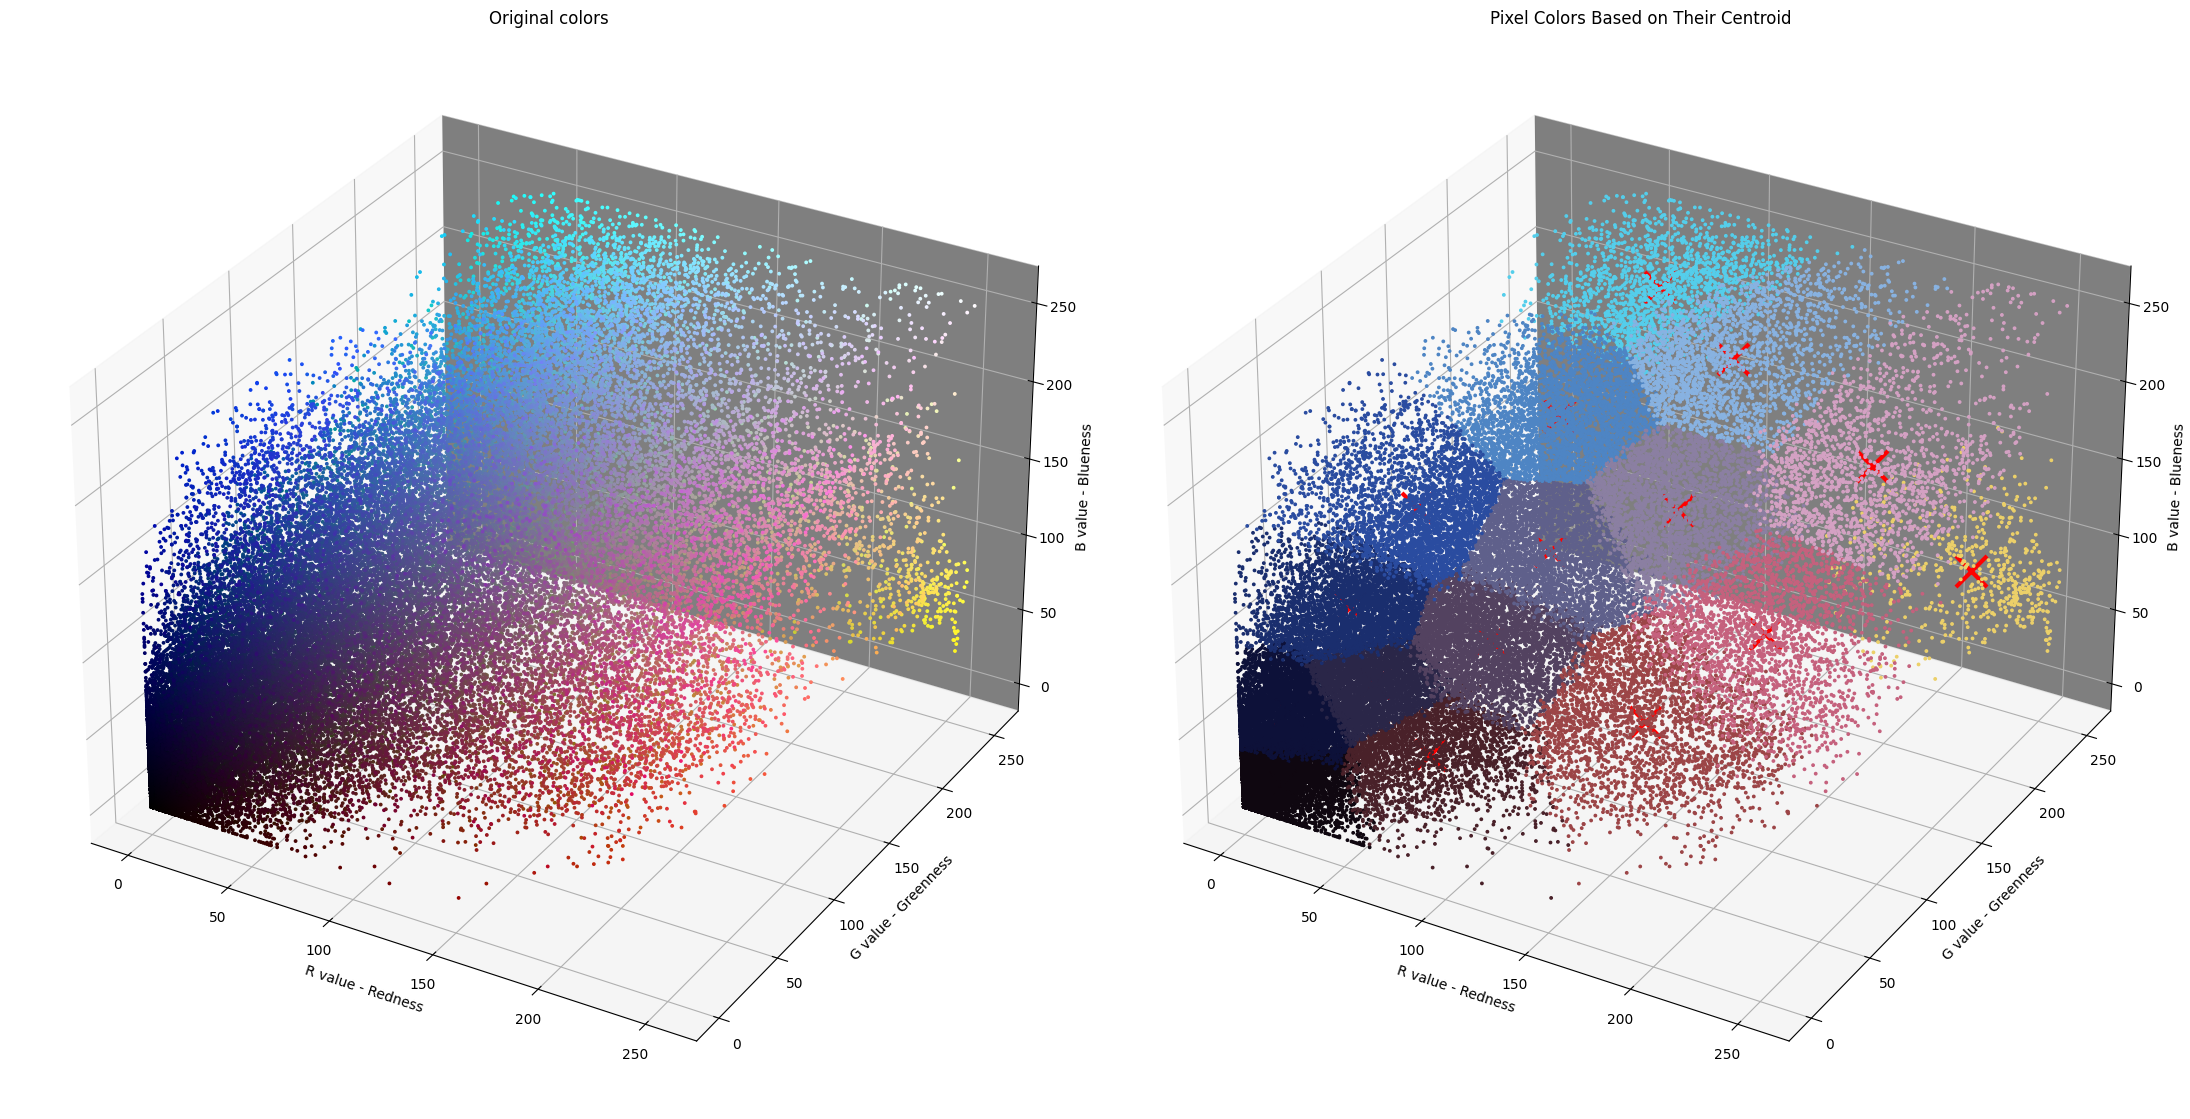

In [87]:
best_centroids = centroids_ar[np.argmin(cost_ar)]
best_centroids_idx = idx_ar[np.argmin(cost_ar)]
utils.plot_kMeans_RGB(X_img, best_centroids, best_centroids_idx, sample_size=1000000)

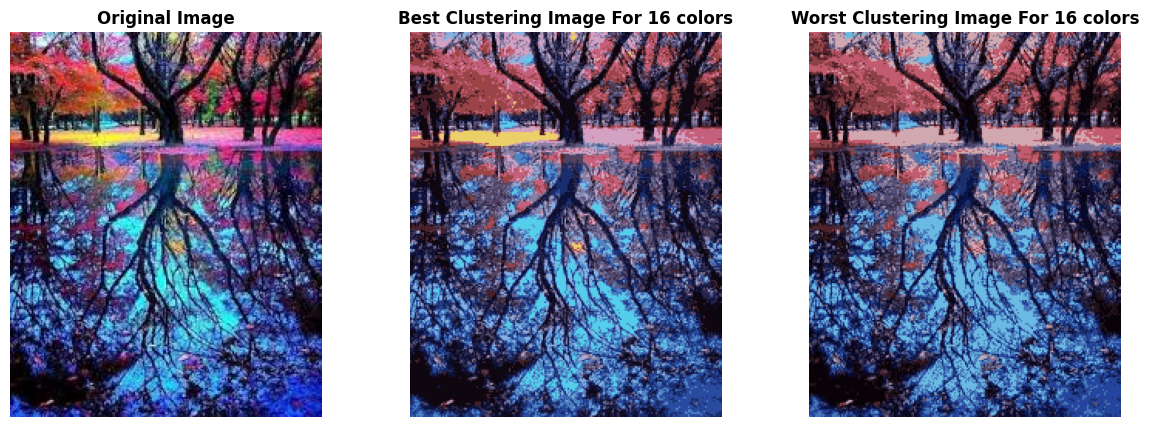

In [88]:

best_image = np.reshape(best_centroids[best_centroids_idx],original_img.shape)


worst_centroids = centroids_ar[np.argmax(cost_ar)]
worst_centroids_idx = idx_ar[np.argmax(cost_ar)]
worst_image = np.reshape(worst_centroids[worst_centroids_idx],original_img.shape)

utils.display_images([original_img, best_image, worst_image],['Original Image', 'Best Clustering Image For 16 colors', 'Worst Clustering Image For 16 colors'])

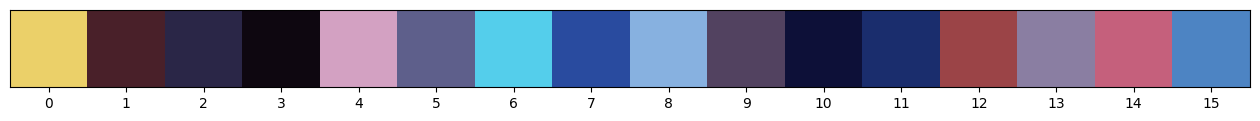

In [89]:
show_centroid_colors(best_centroids)

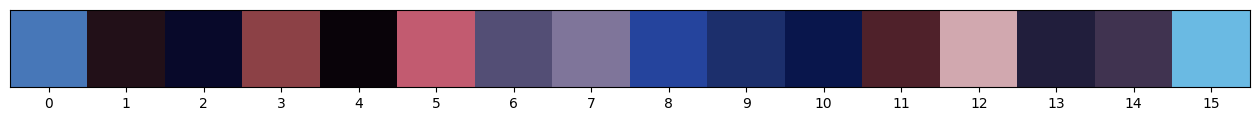

In [90]:
show_centroid_colors(worst_centroids)